In [1]:
import numpy as np
import pyfastchem
import matplotlib.pyplot as plt
import astropy.constants as const
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import os
os.environ['pRT_input_data_path'] = '/Users/salirafi/input_data' # path to the opacity folder

from petitRADTRANS import Radtrans
from petitRADTRANS.physics import guillot_global
import petitRADTRANS.nat_cst as nc

from function import inst_gaussian
from function import rotation_flux
from function import high_pass_filter

In [2]:
class Generate_Model():

    def __init__(self,pressure,temperature,P0,cloud,
                 mol,absorbent_fastchem,absorbent_radtrans):

        """
        pressure    : pressure (bar)
        temperature : temperature (K)
        """

        self.pressure = pressure
        self.temperature = temperature
        self.P0 = P0
        self.cloud = cloud
        self.mol = mol
        self.absorbent_fastchem = absorbent_fastchem
        self.absorbent_radtrans = absorbent_radtrans

    # function for model generation (using petitRADTRANS) assuming chemical equilibrium abundances
    def modeling(self, fastchem, output_data, **kwargs):

        """
        If a constant VMR is assumed, then the species of interest will be the only species with a constant VMR. The rest assumes chemical equilibrium.
        It is important to note that this does not represent any real physical condition.
        """

        # common input for all molecules

        # define reference radius and gravity at arbitrary pressure (which is assumed at the planetary surface with a pressure of P0)
        R_pl = self.Rp * nc.r_jup_mean                      # meter
        gravity = nc.G * self.Mp * nc.m_jup / R_pl ** 2     # meter per second squared

        ######################### Calculating VMR, mass fractions, and MMW from fastChem output #########################

        # getting the mass densities (in molecules cm^-3)
        number_densities = np.array(output_data.number_densities)

        # total gas particle number density (molecules cm^-3) from ideal gas law, used later to convert the number densities to mixing ratios
        gas_number_density = self.pressure * 1e6 / (const.k_B.cgs * self.temperature)

        # if the species of interest is assumed with constant VMR
        if kwargs['homogeneous']:
            for idx,const_spec in enumerate(kwargs['constant_species']):
                number_densities[:, fastchem.getGasSpeciesIndex(const_spec)] = kwargs['constant_mixing_ratio'][idx] * gas_number_density

        # calculate mixing ratios
        mixing_ratios = number_densities / gas_number_density[:,np.newaxis]

        # getting the molecular weight
        molec_weight = np.zeros((fastchem.getGasSpeciesNumber()))
        for species_idx in range(fastchem.getGasSpeciesNumber()):
            molec_weight[species_idx] = fastchem.getGasSpeciesWeight(species_idx)

        # calculate mass fractions
        mass_densities = number_densities * molec_weight[np.newaxis, :]
        mass_fractions = mass_densities / np.sum(mass_densities, axis=1)[:, np.newaxis]

        # calculate the mean molecular weight
        mmw = np.sum(mixing_ratios*molec_weight[np.newaxis,:],axis=1)
        # mmw_fastchem = np.array(output_data.mean_molecular_weight)

        # defining mass fractions dictionary for petitRADTANS
        mass_frac = {}
        for idx,abso in enumerate(self.absorbent_fastchem):
            mass_frac[self.absorbent_radtrans[idx]] = mass_fractions[:, fastchem.getGasSpeciesIndex(abso)]

        # calculate the transmission spectrum
        if self.cloud == False:
            self.mol.calc_transm(self.temperature, mass_frac, gravity, np.asarray(mmw), 
                                 R_pl = R_pl, P0_bar = self.P0)
        else:
            self.mol.calc_transm(self.temperature, mass_frac, gravity, np.asarray(mmw), 
                                 R_pl = R_pl, P0_bar = self.P0, Pcloud = self.cloud)

        return nc.c / self.mol.freq, 1 - np.square(self.mol.transm_rad / (self.Rs * nc.r_sun))  # wavelength in cm, flux in 1-(Rp/Rs)^2
    
    # function for generating model (using petitRADTRANS) assuming constant VMR
    def modeling_constant_VMR(self, vmr, fastchem):

        # common input for all molecules

        # define reference radius and gravity at arbitrary pressure (which is assumed at the planetary surface with a pressure of 1 bar)
        R_pl = self.Rp * nc.r_jup_mean
        gravity = nc.G * self.Mp * nc.m_jup / R_pl ** 2

        ######################### Calculating homogenous abundances #########################

        # getting the molecular weight
        molec_weight = np.zeros((len(self.absorbent_fastchem)))
        for idx,species in enumerate(self.absorbent_fastchem):
            molec_weight[idx] = fastchem.getGasSpeciesWeight(fastchem.getGasSpeciesIndex(species))

        # calculate MMW
        mmw = np.sum(vmr * molec_weight) #* np.ones_like(pressure)

        # converting mixing ratios to mass fractions
        mass_fractions = molec_weight * vmr / mmw

        # defining mass fractions dictionary for petitRADTANS
        mass_frac = {}
        for idx,abso in enumerate(self.absorbent_fastchem):
            mass_frac[self.absorbent_radtrans[idx]] = mass_fractions[idx] * np.ones_like(self.pressure)

        # calculate the transmission spectrum
        if self.cloud == False:
            self.mol.calc_transm(self.temperature, mass_frac, gravity, mmw*np.ones_like(self.pressure), 
                                 R_pl = R_pl,P0_bar = self.P0)
        else:
            self.mol.calc_transm(self.temperature, mass_frac, gravity, mmw*np.ones_like(self.pressure), 
                                 R_pl = R_pl, P0_bar = self.P0, Pcloud = self.cloud)

        return nc.c / self.mol.freq, 1 - np.square(self.mol.transm_rad / (self.Rs * nc.r_sun))  # wavelength in cm, flux in 1-(Rp/Rs)^2
    
    # function for convolving model with instrument resolution and rotational broadening
    def model_prepare(self, metallicity, CO_rat, R_data, vsini, limb_coeff, binmedfil, bingauss, R_model=1e6, plot=True, homo=False, vmr_constant=False, normalize=False, divide_normalization=False):

        # calculate instrumental FWHM
        c = const.c.value / 1000. # km/s
        FWHM = c / R_data

        # convolving model with Gaussian kernel (function needs x-axis to be evenly sampled in velocity or log-wavenumber; Kawahara+ 2022)
        max_wavenum,min_wavenum = 1/self.wave_model[0], 1/self.wave_model[-1] # cm^-1
        N_wvbin = int(R_model * np.log(max_wavenum/(min_wavenum-5)) + 1.) # from Kawahara+ (2022)
        wavenum = np.logspace(np.log10(min_wavenum), np.log10(max_wavenum), N_wvbin, dtype=np.float64) # define the wavenumber in linear logarithm space since we want to define the kernel in velocity space
        flux_transm_wvnum = interp1d(1/self.wave_model,self.flux_model,kind='cubic',fill_value='extrapolate')(wavenum)
        flux_mod_planet = inst_gaussian(wavenum,flux_transm_wvnum,FWHM) # as a function of wavenumber

        # rotationally broadened model (function needs x-axis to be evenly spaced)
        wave_even = np.arange((1/wavenum*1e+8)[-1],(1/wavenum*1e+8)[0],0.01) # convert cm to angstrom
        flux_mod_planet_even = interp1d(1/wavenum*1e+8,flux_mod_planet,kind='cubic',fill_value='extrapolate')(wave_even)
        flux_broad = rotation_flux(wave_even,flux_mod_planet_even,vsini,limb_coeff[0],limb_coeff[1])

        # applying high-pass filter to fit pseudo-continuum
        med_fil = high_pass_filter(flux_broad[50:-50],binmedfil,maxval=True) # use the maximum value
        gauss_fil = gaussian_filter1d(med_fil,bingauss)

        # normalizing model by division to preserve the line shape and contrast (line depth relative to continuum) or subtract it since we want the model to have 0 continuum
        if normalize:
            flux_modelmol = flux_broad[50:-50] / gauss_fil if divide_normalization else flux_broad[50:-50] - gauss_fil
        else:
            flux_modelmol = flux_broad[50:-50]

        wave_modelmol = wave_even[50:-50]

        if plot:
            plt.figure(figsize=(20,10))
            plt.subplot(211)
            plt.plot(self.wave_model[50:-50]*1e+8,self.flux_model[50:-50],label='Initial')
            plt.plot(1/wavenum[50:-50]*1e+8,flux_mod_planet[50:-50],label='Gaussian-convolved')
            plt.plot(wave_even[50:-50],flux_broad[50:-50],label='Rotationally-broadened')
            plt.plot(wave_even[50:-50],gauss_fil,label='High-pass filter')
            # # plt.plot(wave_even[50:-50],fit_continuum,label='High-pass filter')
            plt.ylabel(r'$1-\rm (R_p/R_s)^2$')
            plt.xlabel(r'Wavelength ($\AA$)')
            if homo:
                plt.title('HD 149026 b ' + str(self.absorbent_radtrans)+' spectrum (C/O = '+str(CO_rat)+', Fe/H = '+str(metallicity)+r', $T_{eff}$ = '\
                    +str(int(np.mean(self.temperature)))+' K, cloud = '+str(self.cloud)+', Vsin(i) = '+str(round(vsini,2))+', VMR = '+str(vmr_constant)+')')
            else:
                plt.title('HD 149026 b ' + str(self.absorbent_radtrans) + ' spectrum (C/O = ' + str(CO_rat) + ', Fe/H = ' + str(metallicity) + r', $T_{eff}$ = '\
                        + str(int(np.mean(self.temperature))) + ' K, cloud = ' + str(self.cloud) +', Vsin(i) = ' +str(round(vsini,2))+ ')')
            plt.legend()
            
            plt.subplot(212)
            plt.plot(wave_modelmol,flux_modelmol)
            plt.show(block=False)

            plt.show()
            plt.clf()

        return wave_modelmol,flux_modelmol

# Single-species Model

## Chemical Equilibrium Abundances

/Users/salirafi/Documents/GitHub/High-Resolution-Spectroscopy-Analysis-for-HD-149026-b/py3918env/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_POKAZATEL_cust...

  Read CIA opacities for H2-He...
  Read CIA opacities for H2-H2...
Done.


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensates: 0



/Users/salirafi/Documents/GitHub/High-Resolution-Spectroscopy-Analysis-for-HD-149026-b/function.py:145: RuntimeWarning: invalid value encountered in sqrt
  kernel = np.where(eta <= 1.0, np.pi / 2.0 * u1 * (1.0 - eta) - 2.0 / 3.0 * np.sqrt(1.0 - eta) * (3.0*u1 + u2 + 2.0*u2*eta**2 - 3.0), 0.0) # accounting NaN values caused by the square root


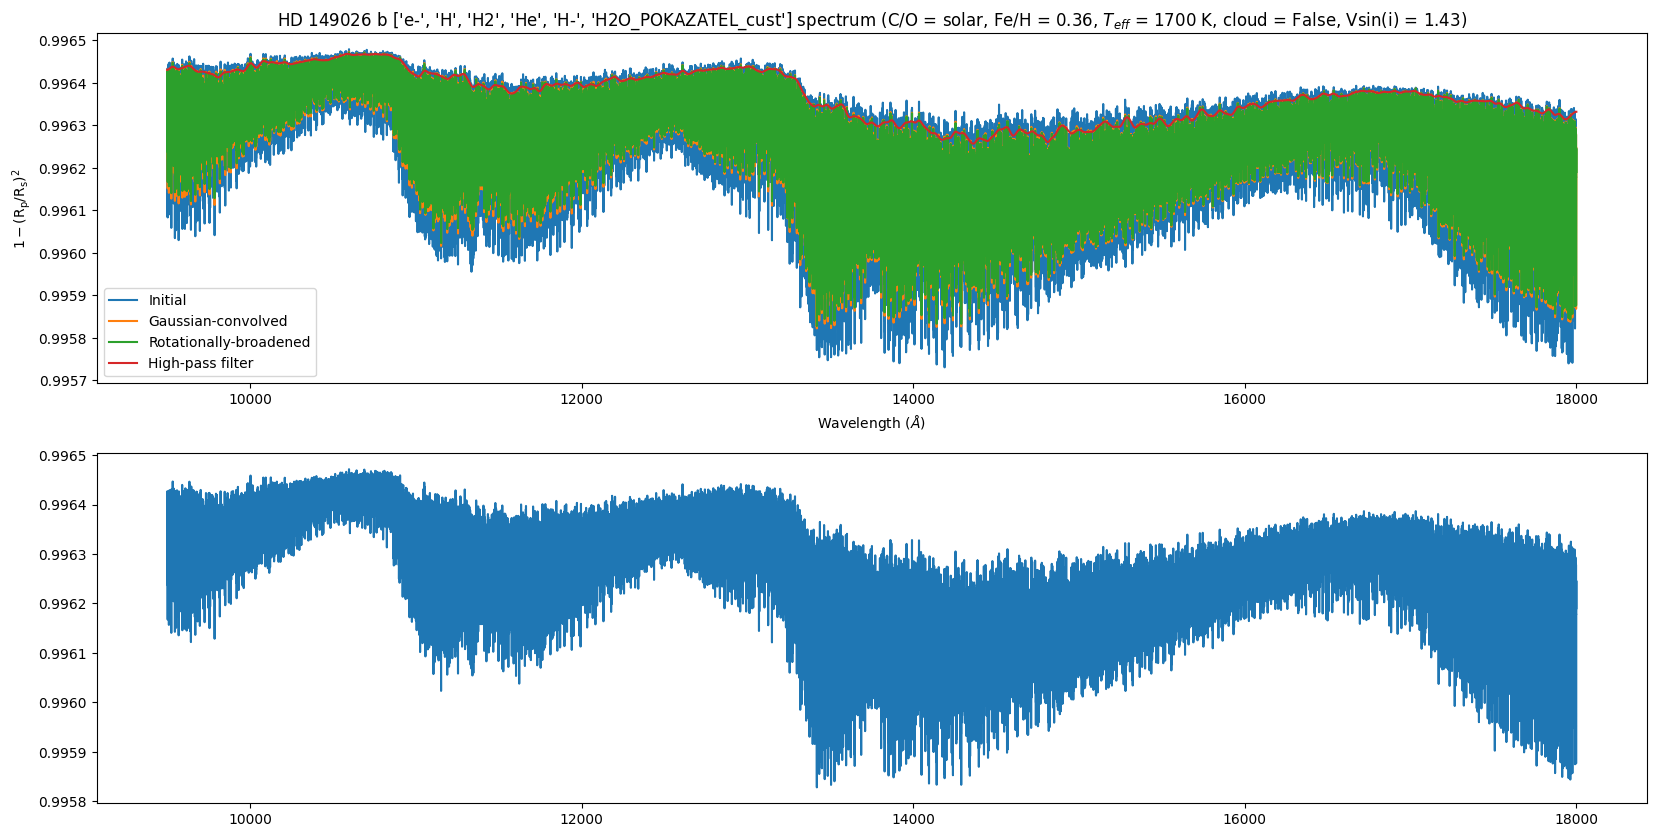

<Figure size 640x480 with 0 Axes>

In [3]:
# for isothermal TP-profile and non-homogenous atmosphere or VMR constant for only one species of interest

Rs = 1.41         # Sun radii, from Stassun+ 2017
ap = 0.04364      # AU, from Bonomo+ 2017
Ts = 6179         # K, from Stassun+ 2017
Mp = 0.322        # Jupiter mass, from Bonomo+ 2017
Rp = 0.811        # Jupiter radii, from Bonomo+ 2017

pressure = np.logspace(-8,2,100)                            # bar
t_eq = 1700                                                 # Kelvin (assuming eq. temperature)
temperature = t_eq * np.ones_like(pressure)                 # isothermal profile
P0 = 10                                                     # bar
CO_rat = 'solar'
metallicity = 0.36
cloud = False                                             # cloud deck pressure in log10 bar; since we set the surface at P0, then P0 cloud is basically cloud-free

######################### Guillot profile #########################

# # below if Guillot (2010) profile is desired

# R_pl = Rp * nc.r_jup_mean
# gravity = nc.G * Mp * nc.m_jup / R_pl ** 2

# t_eq = t_eq # float(input('t_eq: '))
# kappa_IR = 0.01  # float(input('kappa_IR: '))
# gamma = 0.5  # float(input('gamma: ')) #0.5
# T_int = 0.39 * t_eq * np.exp(-np.square(np.log10(4 * nc.sigma * t_eq ** 4 / 1e+9) - 0.14) / 1.095)  # flux in Gerg s^-1 cm^-2 (Thorngren+ 2019)
# T_equ = Ts * np.sqrt(Rs * nc.r_sun / 2 / ap / nc.AU)                                                # follwing Guillot+ (2010)
# temperature = guillot_global(pressure, kappa_IR, gamma, gravity, T_int, T_equ)

###########################################################################

line_list = ['H2O_POKAZATEL_cust']                        # opacity folder name in 'pRT_input_data_path'
fastchem_species_symbol = ['H2O1']                        # species name in fastchem format
# line_list = ['HCN_main_iso']
# fastchem_species_symbol = ['C1H1N1_1']

# includes H- opacity
absorbent_fastchem = ['e-','H','H2','He','H1-'] + fastchem_species_symbol
absorbent_radtrans = ['e-','H','H2','He','H-']+ line_list

constant = {}
constant['homogeneous'] = False
constant['constant_species'] = [fastchem_species_symbol]
constant['constant_mixing_ratio'] = [0]

element_abund_file,element_thermo_file = 'fastchem_input/element_abundances_solar_ext.dat','fastchem_input/logK_ext.dat'

################################# Defining Radtrans object #####################################

mol = Radtrans(line_species = line_list,
              rayleigh_species = ['H2', 'He'],
              continuum_opacities = ['H-','H2-He' ,'H2-H2'],
              mode = 'lbl',
              wlen_bords_micron = [0.95, 1.8])
mol.setup_opa_structure(pressure)

############# Abundance from FastCHEM (FastCHEM assumes radiative chemical equilibrium) #############

# defining fastchem object (first arg is the chemical abundance of the star, second arg is the thermochemical data for the species)
fastchem = pyfastchem.FastChem(element_abund_file, element_thermo_file, 1)

# make a copy of the abundances from FastChem
abundances = np.array(fastchem.getElementAbundances())
element_abundances = np.copy(abundances)

# scale the element abundances with metallicity, except those of H and He
for j in range(0, fastchem.getElementNumber()):
    if fastchem.getGasSpeciesSymbol(j) != 'H' and fastchem.getGasSpeciesSymbol(j) != 'He':
        element_abundances[j] *= metallicity

# scale C and O abundance with C/O ratio
if CO_rat != 'solar':
    index_C = fastchem.getGasSpeciesIndex('C')
    index_O = fastchem.getGasSpeciesIndex('O')
    element_abundances[index_C] = element_abundances[index_O] * CO_rat
else: pass

fastchem.setElementAbundances(element_abundances)

# inputting the T-P profile
fastchem_input = pyfastchem.FastChemInput()
fastchem_input.temperature = temperature
fastchem_input.pressure = pressure

fastchem_output = pyfastchem.FastChemOutput()

# calculating the number densities
fastchem_flag = fastchem.calcDensities(fastchem_input, fastchem_output)

####################################### Generating the model #######################################

# initiate class instance
model = Generate_Model(pressure,temperature,P0,cloud,mol,absorbent_fastchem,absorbent_radtrans)

model.Rs = Rs
model.ap = ap
model.Ts = Ts
model.Mp = Mp
model.Rp = Rp

# generating the model using petitRADTRANS
model.wave_model, model.flux_model = model.modeling(fastchem,fastchem_output,**constant)

P = 2.8758916                                                       # days, from Bonomo+ 2017                                      
vsini = 2 * np.pi * model.Rp * nc.r_jup_mean/100000 / (P*86400)     # in km/s --> 2*pi*R/P (assuming circular orbit)
limb_coeff = [0.075, 0.372]                                         # quadratic limb darkening (calculated from https://exoctk.stsci.edu/limb_darkening)
R_data = 80400
binmedfil,bingauss = 2000,1500

wave_h2o, flux_h2o = model.model_prepare(metallicity, CO_rat, R_data, vsini, limb_coeff, binmedfil, bingauss, normalize=False, divide_normalization=False)

In [4]:
#saving model
import pickle
with open('models/HD149026b_H2OPOKAZ_FeH0d36_COsolar_isoTeff1700_cloudFalseP010_abundCE_vorbplanet_flux_nonnormalized.pkl', 'wb') as f:
    pickle.dump(flux_h2o, f)
with open('models/HD149026b_H2OPOKAZ_FeH0d36_COsolar_isoTeff1700_cloudFalseP010_abundCE_vorbplanet_wave_nonnormalized.pkl', 'wb') as f:
    pickle.dump(wave_h2o, f)

## Constant Abundances

  Read line opacities of H2O_POKAZATEL_cust...

  Read CIA opacities for H2-He...
  Read CIA opacities for H2-H2...
Done.


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensates: 0



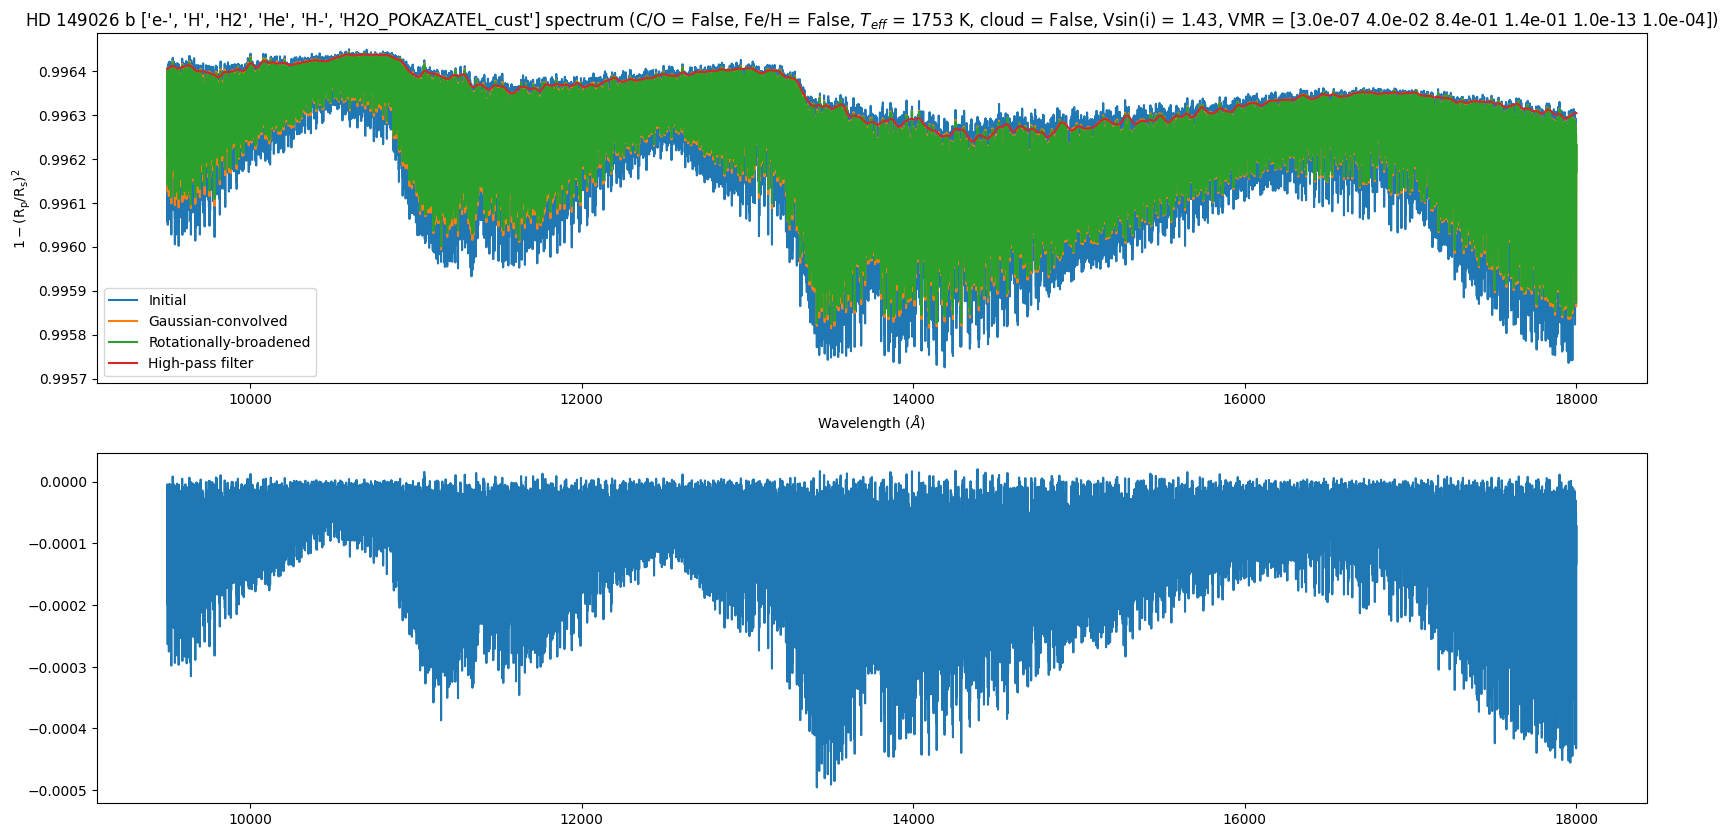

<Figure size 640x480 with 0 Axes>

In [9]:
# for isothermal TP-profile and homogenous atmosphere with VMR taken form the mean/median of the chemical equilinrium abundances (C/O and [Fe/H] aren't relevant)

Rs = 1.41         # Sun radii, from Stassun+ 2017
ap = 0.04364      # AU, from Bonomo+ 2017
Ts = 6179         # K, from Stassun+ 2017
Mp = 0.322        # Jupiter mass, from Bonomo+ 2017
Rp = 0.811        # Jupiter radii, from Bonomo+ 2017

pressure = np.logspace(-8,2,100)                            # bar
temperature = 1700 * np.ones_like(pressure)                  # isothermal profile (assuming equilibrium temperature)
P0 = 10                                                      # bar
metallicity = False
CO_rat = False
cloud = False                                               # cloud deck pressure in log10 bar

######################### Guillot profile #########################

# # below if Guillot (2010) profile is desired

# R_pl = Rp * nc.r_jup_mean
# gravity = nc.G * Mp * nc.m_jup / R_pl ** 2

# t_eq = t_eq # float(input('t_eq: '))
# kappa_IR = 0.01  # float(input('kappa_IR: '))
# gamma = 0.5  # float(input('gamma: ')) #0.5
# T_int = 0.39 * t_eq * np.exp(-np.square(np.log10(4 * nc.sigma * t_eq ** 4 / 1e+9) - 0.14) / 1.095)  # flux in Gerg s^-1 cm^-2 (Thorngren+ 2019)
# T_equ = Ts * np.sqrt(Rs * nc.r_sun / 2 / ap / nc.AU)                                                # follwing Guillot+ (2010)
# temperature = guillot_global(pressure, kappa_IR, gamma, gravity, T_int, T_equ)

###########################################################################

line_list = ['H2O_POKAZATEL_cust']                                  # opacity folder name in 'pRT_input_data_path'
fastchem_species_symbol = ['H2O1']                        # species name in fastchem format

# includes H- opacity
absorbent_fastchem = ['e-','H','H2','He','H1-'] + fastchem_species_symbol
absorbent_radtrans = ['e-','H','H2','He','H-']+ line_list

element_abund_file,element_thermo_file = 'fastchem_input/element_abundances_solar_ext.dat','fastchem_input/logK_ext.dat'

################################# Defining Radtrans object #####################################

mol = Radtrans(line_species = line_list,
              rayleigh_species = ['H2', 'He'],
              continuum_opacities = ['H-','H2-He' ,'H2-H2'],
              mode = 'lbl',
              wlen_bords_micron = [0.95, 1.8])
mol.setup_opa_structure(pressure)

fastchem = pyfastchem.FastChem(element_abund_file, element_thermo_file, 1)

vmr_h = 0.04                                                    # VMR
vmr_elec = 3e-7                                                 # VMR
vmr_hminus = 1e-13                                              # VMR; H and electron don't have opacities in NIR so only H- abundances will be used
vmr_h2 = 0.84                                                   # VMR
vmr_he = 0.14                                                   # VMR
vmr_spec_log = -4.0 # np.arange(-10.,-1.5,0.5)                  # species of interest VMR in log10

vmr_log = 10**vmr_spec_log

vmr = np.array([vmr_elec,vmr_h,vmr_h2,vmr_he,vmr_hminus,vmr_log])

# initiate class instance
model = Generate_Model(pressure,temperature,P0,cloud,mol,absorbent_fastchem,absorbent_radtrans)

model.Rs = Rs
model.ap = ap
model.Ts = Ts
model.Mp = Mp
model.Rp = Rp

if not cloud: pass
else: model.cloud = 10**cloud

# generating the model using petitRADTRANS
model.wave_model, model.flux_model = model.modeling_constant_VMR(vmr, fastchem)

P = 2.8758916                                                       # days (Bonomo+ 2017)                                         
vsini = 2 * np.pi * model.Rp * nc.r_jup_mean/100000 / (P*86400)     # in km/s
limb_coeff = [0.075, 0.372]                                         # quadratic limb darkening (calculated from https://exoctk.stsci.edu/limb_darkening)
R_data = 80400
binmedfil,bingauss = 2000,1500

# convolve and normalize model
wave_h2o_constant, flux_h2o_constant = model.model_prepare(metallicity, CO_rat, R_data, vsini, limb_coeff, binmedfil, bingauss, homo=True, vmr_constant=vmr, normalize=True)

In [20]:
#saving model
import pickle
with open('models/HD149026b_H2OPOKAZ_FeHundef_COundef_isoTeff1700_cloudFalse_constabund_flux_normalized.pkl', 'wb') as f:
    pickle.dump(flux_h2o_constant, f)
with open('models/HD149026b_H2OPOKAZ_FeHundef_COundef_isoTeff1700_cloudFalse_constabund_wave_normalized.pkl', 'wb') as f:
    pickle.dump(wave_h2o_constant, f)

# Plots for Paper

In [28]:
# absorbent_fastchem = ['H2O1']

# pressure = np.logspace(-8,2,100)                            # bar
# t_eq = 1700                                                 # Kelvin
# temperature = t_eq * np.ones_like(pressure)                 # isothermal profile (assuming equilibrium temperature)

# element_abund_file,element_thermo_file = 'fastchem_input/element_abundances_solar_ext.dat','fastchem_input/logK_ext.dat'
# fastchem = pyfastchem.FastChem(element_abund_file, element_thermo_file, 1)

# CO_rat = 0.55
# metallicity = 0.36
# abundances = np.array(fastchem.getElementAbundances())
# element_abundances = np.copy(abundances)
# for j in range(0, fastchem.getElementNumber()):
#     if fastchem.getGasSpeciesSymbol(j) != 'H' and fastchem.getGasSpeciesSymbol(j) != 'He':
#         element_abundances[j] *= metallicity
# index_C = fastchem.getGasSpeciesIndex('C')
# index_O = fastchem.getGasSpeciesIndex('O')
# element_abundances[index_C] = element_abundances[index_O] * CO_rat
# fastchem.setElementAbundances(element_abundances)

# fastchem_input = pyfastchem.FastChemInput()
# fastchem_input.temperature = temperature
# fastchem_input.pressure = pressure
# fastchem_output = pyfastchem.FastChemOutput()
# fastchem_flag = fastchem.calcDensities(fastchem_input, fastchem_output)
# number_densities = np.array(fastchem_output.number_densities)
# gas_number_density = pressure * 1e6 / (const.k_B.cgs * temperature)
# mixing_ratios_h2o = number_densities / gas_number_density[:,np.newaxis]


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensates: 0



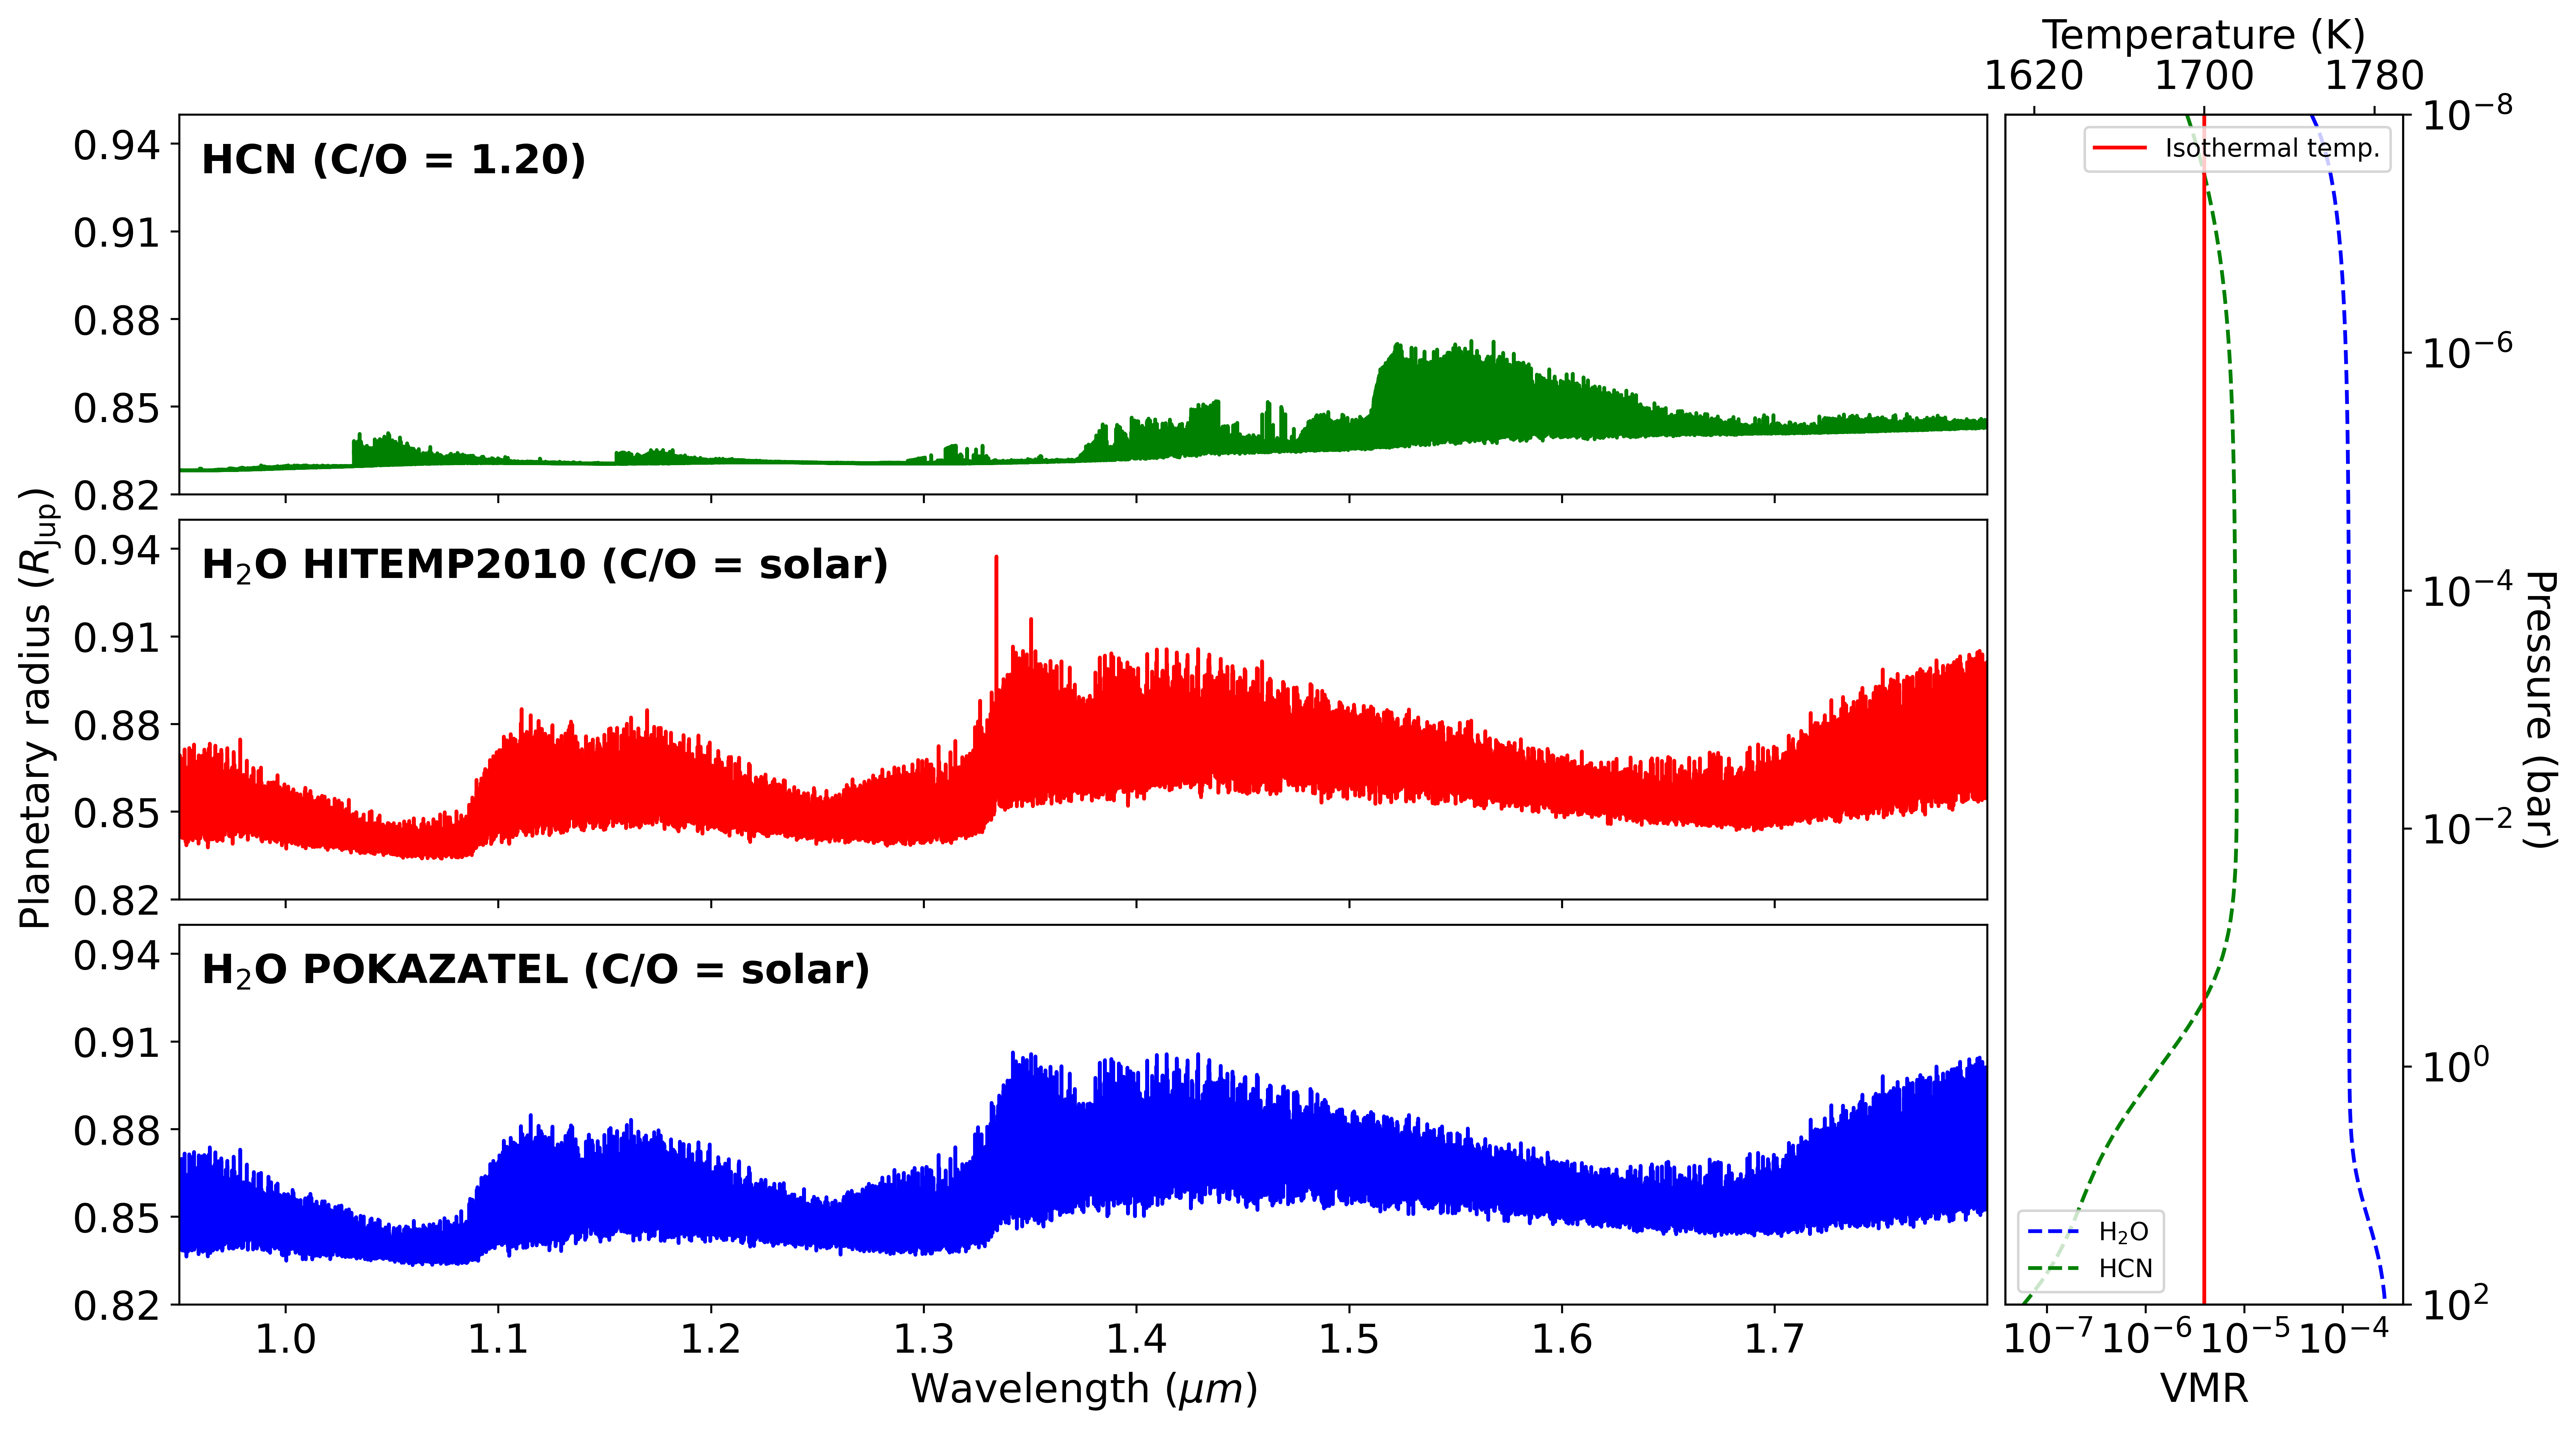

<Figure size 640x480 with 0 Axes>

In [31]:
# fig = plt.figure(figsize=(10, 7),dpi=500)

# lbl = 16

# axes_h2o = [0, 0, 1, 0.3]
# axes_h2o_hitemp = [0, 0+0.32, 1, 0.3]
# axes_hcn = [0, 0+0.32+0.32, 1, 0.3]
# axes_combined = [0+1.01, 0, 0.22, 0.32+0.32+0.3]

# h2o = plt.axes(axes_h2o)
# h2o_hitemp = plt.axes(axes_h2o_hitemp)
# hcn = plt.axes(axes_hcn)
# combined = plt.axes(axes_combined)

# hcn.plot(wave_hcn*1e-4,flux_hcn/nc.r_jup_mean,c='green',label='HCN')
# hcn.set_xticklabels([])
# hcn.set_xlim(wave_h2o_hitemp[0]*1e-4,wave_h2o_hitemp[-1]*1e-4)
# hcn.tick_params(axis='both', which='major', labelsize=lbl)
# hcn.text(0.96,0.93,r'HCN (C/O = 1.20)',color='black',weight='bold',fontsize=lbl)
# hcn.set_ylim(0.82,0.95)
# hcn.set_yticks([0.82,0.85,0.88,0.91,0.94])
# # hcn.legend()

# h2o_hitemp.plot(wave_h2o_hitemp*1e-4,flux_h2o_hitemp/nc.r_jup_mean,c='red',label=r'H$_2$O HITEMP2010')
# h2o_hitemp.set_ylabel(r'Planetary radius ($R_\mathrm{Jup}$)',fontsize=lbl)
# h2o_hitemp.set_xticklabels([])
# h2o_hitemp.set_xlim(wave_h2o_hitemp[0]*1e-4,wave_h2o_hitemp[-1]*1e-4)
# h2o_hitemp.set_ylim(0.82,0.95)
# h2o_hitemp.set_yticks([0.82,0.85,0.88,0.91,0.94])
# h2o_hitemp.tick_params(axis='both', which='major', labelsize=lbl)
# h2o_hitemp.text(0.96,0.93,r'H$_2$O HITEMP2010 (C/O = solar)',color='black',weight='bold',fontsize=lbl)
# # h2o_hitemp.legend()

# h2o.plot(wave_h2o*1e-4,flux_h2o/nc.r_jup_mean,c='blue',label=r'H$_2$O POKAZATEL')
# h2o.set_xlabel(r'Wavelength ($\mu m$)',fontsize=lbl)
# h2o.set_xlim(wave_h2o_hitemp[0]*1e-4,wave_h2o_hitemp[-1]*1e-4)
# h2o.set_ylim(0.82,0.95)
# h2o.set_yticks([0.82,0.85,0.88,0.91,0.94])
# h2o.tick_params(axis='both', which='major', labelsize=lbl)
# h2o.text(0.96,0.93,r'H$_2$O POKAZATEL (C/O = solar)',color='black',weight='bold',fontsize=lbl)
# # h2o.legend()

# abs = [r'H$_2$O','HCN','CH$_4$']
# absorbent_fastchem = ['H2O1','C1H1N1_1','C1H4']
# # for idx,abso in enumerate(absorbent_fastchem):
# combined.plot(mixing_ratios_h2o[:, fastchem.getGasSpeciesIndex(absorbent_fastchem[0])],pressure,label=abs[0],ls='--',c='blue')
# combined.plot(mixing_ratios_hcn[:, fastchem.getGasSpeciesIndex(absorbent_fastchem[1])],pressure,label=abs[1],ls='--',c='green')
# combined.set_xscale('log')
# combined.set_yscale('log')
# combined.set_xlabel('VMR',fontsize=lbl)
# combined.set_ylabel('Pressure (bar)', rotation=270, labelpad=18,fontsize=lbl)
# combined.yaxis.set_label_position("right")
# combined.yaxis.set_ticks_position('right')
# # ax1.set_gca().invert_yaxis()
# combined.set_ylim(100,1e-8)
# combined.set_xticks([1e-7,1e-6,1e-5,1e-4])
# combined.tick_params(axis='both', which='major', labelsize=lbl)
# combined.legend(loc='lower left')

# combined2 = combined.twiny()
# combined2.axvline(x=1700,c='red',label='Isothermal temp.')
# combined2.set_xlabel('Temperature (K)',fontsize=lbl)
# combined2.tick_params(axis='both', which='major', labelsize=lbl)
# combined2.set_xticks([1620,1700,1780])
# combined2.legend()

# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
# plt.savefig("figures/models_rev.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)
# plt.show(block=False)
# plt.clf()